In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import pyodbc
from collections import OrderedDict
from itertools import product
from copy import copy, deepcopy

from sklearn.preprocessing import StandardScaler

In [4]:
def get_rfm_query(typ, count=1000):
    query = """
            select {top} c.Id CustId
                ,{field}

                from directcrm.Customers c
                    join directcrm.CustomerActions ca on c.Id = ca.CustomerId
                    join directcrm.RetailOrders ro on ca.Id = ro.FirstCustomerActionId
                    join directcrm.RetailOrderHistory roh on ro.Id = roh.OrderId
                    join directcrm.RetailPurchaseHistory rph on roh.id = rph.OrderHistoryItemId
                    join directcrm.RetailPurchaseStatuses rps on rph.StatusId = rps.Id

                where rps.CategorySystemName not in ('Returned','Cancelled','InCart') and roh.IsCurrentOtherwiseNull = 1

                group by c.Id

                order by c.Id
            """
    
    fields = {'r': 'DateDiff(hh, Max(ca.DateTimeUtc), GetDate()) Recency_hours',
              'f': 'Count(ca.Id) CountActions',
              'm': 'Sum(roh.EffectivePayedAmount) Amount'}
    
    top = ''
    if count is not None:
        top = "top({})".format(count)
    
    query = query.format(top=top, field=fields[typ])
    return query


def get_rfm_data(cnxn, typ, count=1000):
    cursor = cnxn.cursor()
    cursor.execute(get_rfm_query(typ, count))
    rows = list(map(lambda t: [t[0], t[1]], cursor.fetchall()))
    df = pd.DataFrame(rows, columns=['id', 'rfm_{}'.format(typ)])
    return df


def get_full_rfm_data(count = 100): 
    cnxn = pyodbc.connect(driver='{SQL Server}',
                          server='aurora',
                          database='hoff')
    data_r = get_rfm_data(cnxn, 'r', count=count)
    data_f = get_rfm_data(cnxn, 'f', count=count)
    data_m = get_rfm_data(cnxn, 'm', count=count)
    cnxn.close()
    
    if sum (data_r.id != data_f.id) or sum(data_r.id != data_m.id):
        raise RuntimeError("Не совпадают индексы")
    else:
        data = pd.concat([data_r, data_f.drop('id', axis=1), data_m.drop('id', axis=1)], axis=1)
    data['rfm_m'] = data['rfm_m'].astype(float)
    return data


def reduce_tails(data, min_q=0.025, max_q=0.975):
    filtered_data = data[(data['rfm_r'] >= data['rfm_r'].quantile(min_q)) &
                         (data['rfm_r'] <= data['rfm_r'].quantile(max_q)) &
                         (data['rfm_f'] >= data['rfm_f'].quantile(min_q)) &
                         (data['rfm_f'] <= data['rfm_f'].quantile(max_q)) &
                         (data['rfm_m'] >= data['rfm_m'].quantile(min_q)) &
                         (data['rfm_m'] <= data['rfm_m'].quantile(max_q))]
    return filtered_data


def draw_3d_plot(data, view=(30, -60), labels=None):
    fig = plt.figure()
    ax = Axes3D(fig)
    
    ax.set_xlabel("R")
    ax.set_ylabel("F")
    ax.set_zlabel("M")
    ax.view_init(view[0], view[1])
    
    if labels is None:
        x = list(data['rfm_r'])
        y = list(data['rfm_f'])
        z = list(data['rfm_m'])
        ax.scatter(x, y, z)
        
    else:
        for n in np.unique(labels):
            indices = labels == n
            x = list(data.loc[indices, 'rfm_r'])
            y = list(data.loc[indices, 'rfm_f'])
            z = list(data.loc[indices, 'rfm_m'])

            c = [[n * 2 % 256, n * 5 % 256, n * 13 % 256]]
            ax.scatter(x, y, z)
    
    return ax

In [5]:
raw_data = get_full_rfm_data(10000)

In [6]:
percent_to_drop = 2
reduced_data = reduce_tails(raw_data.copy(), percent_to_drop / 2 / 100, 1 - percent_to_drop / 2 / 100)
print('Losted: {}%'.format((1 - reduced_data.shape[0] / raw_data.shape[0]) * 100))

Losted: 4.300000000000004%


In [7]:
data = reduced_data
X = data[['rfm_r', 'rfm_f', 'rfm_m']]
X_scaled_std = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

In [1]:
#draw_3d_plot(X)

In [10]:
#draw_3d_plot(X_scaled_std)

# Алгоритмы

**Решено использовать Standard Scaling (считать только с ним!)**

## Выбранные алгоритмы

1. **K-means** - классика, без него никуда.
Простой и понятный.  
*Достоинства*: кластеры выпуклые

2. **Agglomerative clustering** - хороший алгоритм, есть 3 варианта опции "связь". Быстрый.
*Достоинства*: Гораздо умнее, чем k-means
*Недостатки*: невыпуклые кластеры -> будем следить, чтобы ложились в параллелепипеды

2. **<font color=#993333>Mean-shift</font>** - Неплохо работает.  
*Недостатки*: Нельзя задать число кластеров -> будем следить, чтобы их число было в заданных пределах <- но это случается редко!

## Метрики, не требующие знания истинных меток классов
*Пока рассматриваем только их*

1. **Silhouette Coefficient** - силуэт. От -1 до +1.

2. **Calinski-Harabaz Index** - быстро считается

In [8]:
from sklearn.metrics import silhouette_score, calinski_harabaz_score
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift

In [9]:
def tuning(X, params, clr, rs=None):
    names = tuple(params.keys())
    values_lists = list(params.values())
    combs = list(product(*values_lists))
    
    results = {'name': clr.__name__, 'params': names}
    results['results'] = OrderedDict()
    for comb in combs:
        kwargs = {name: comb[i] for i, name in enumerate(names)}
        labels = clr(**kwargs).fit(X).labels_
        u_lbs_num = len(np.unique(labels))
        if u_lbs_num > 1:
            m1 = silhouette_score(X, labels, random_state=rs)
            m2 = calinski_harabaz_score(X, labels)
        else:
            m1 = -1
            m2 = -1
        results['results'][comb] = {'labels': labels, 'm1': m1, 'm2': m2}
    
    return results 

In [10]:
def choose_best_result(results):
    combs = list(results.keys())
    m1 = [d['m1'] for d in results.values()]
    m2 = [d['m2'] for d in results.values()]
    lbs = [d['labels'] for d in results.values()]
    
    best_1, best_2 = np.argmax(m1), np.argmax(m2)
    best_comb_1, best_comb_2 = combs[best_1], combs[best_2]
    best_res_1, best_res_2 = m1[best_1], m2[best_2]
    best_lbs_1, best_lbs_2 = lbs[best_1], lbs[best_2]
    return {'m1': {'comb': best_comb_1, 'res': best_res_1, 'labels': best_lbs_1},
            'm2': {'comb': best_comb_2, 'res': best_res_2, 'labels': best_lbs_2}}

In [11]:
def choose_bests(X, n_min, n_max, rs=None, n_jobs=-3):
    """rs = random_state"""
    
    reports = []
    
    # KMeans
    print('KMeans')
    reports.append(tune_kmeans(X, n_min, n_max))
    
    # Agglomerative Clustering
    print('Agglomerative Clustering')
    reports.append(tune_aggclr(X, n_min, n_max))
    
    # Mean-shift
    print('Mean-shift')
    n_min_ext, n_max_ext = n_min - (n_max - n_min) // 3, n_max + (n_max - n_min) // 3
    reports.append(tune_meanshift(X, n_min, n_max))
     
    # Choousing best
    print('Choousing best')
    bests = OrderedDict()
    for i, rep in enumerate(reports):
        bests[rep['name']] = {'params': rep['params'], 
                              'bests': choose_best_result(rep['results'])}
    
    return bests    

In [12]:
def tune_kmeans(X, n_min, n_max, n_jobs):
    params_kmeans = {'n_clusters': list(range(n_min, n_max + 1)),
                     'random_state': [rs],
                     'n_jobs': [n_jobs]}
    report = tuning(X, params_kmeans, KMeans, rs=rs)
    return report

In [13]:
def tune_aggclr(X, n_min, n_max, n_jobs):
    params_agglmrt = {'n_clusters': list(range(n_min, n_max + 1)),
                      'linkage': ['average'],
                      'affinity': ['chebyshev']}
    report = tuning(X, params_agglmrt, AgglomerativeClustering, rs=rs)

In [14]:
def tune_meanshift(X, n_min, n_max, n_jobs):
    params_meanshift = {'cluster_all': [True], 
                        'n_jobs': [n_jobs]}
    report = tuning(X, params_meanshift, MeanShift, rs=rs)
    u_lbs_num = len(np.unique(report['results'][(True, n_jobs)]['labels']))
    if not n_min <= u_lbs_num <= n_max:
        report['results'] = None
    return report

In [15]:
rs=17
n_min, n_max = 8, 14

In [ ]:
bests = choose_bests(X, n_min, n_max, rs=rs, n_jobs=-3)
bests_ = deepcopy(bests)

In [89]:
bests


OrderedDict([('KMeans',
              {'bests': {'m1': {'comb': (8, 17, -3),
                 'labels': array([0, 0, 6, ..., 0, 0, 6]),
                 'res': 0.6427855587540297},
                'm2': {'comb': (14, 17, -3),
                 'labels': array([ 0,  0, 12, ...,  0,  0,  6]),
                 'res': 98659.89159103979}},
               'params': ('n_clusters', 'random_state', 'n_jobs')}),
             ('AgglomerativeClustering',
              {'bests': {'m1': {'comb': (9, 'average', 'euclidean'),
                 'labels': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
                 'res': 0.7558637568668873},
                'm2': {'comb': (14, 'ward', 'euclidean'),
                 'labels': array([8, 8, 0, ..., 0, 8, 6], dtype=int64),
                 'res': 83339.82554788268}},
               'params': ('n_clusters', 'linkage', 'affinity')})])

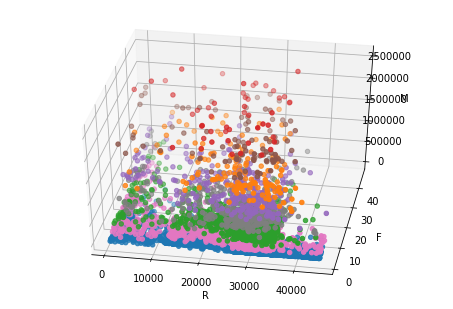

In [90]:
draw_3d_plot(X, (40, -80), bests['KMeans']['bests']['m1']['labels'])

In [16]:
# Custom metric
def max_dist(x, y):
    return np.max(np.abs(x - y))

In [17]:
from sklearn.metrics.pairwise import pairwise_distances, PAIRWISE_KERNEL_FUNCTIONS

In [18]:
X_std_pdists = pairwise_distances(X_scaled_std, metric='chebyshev')

In [46]:
%%timeit
params_agglmrt = {'n_clusters': list(range(n_min, n_max + 1)),
                  'linkage': ['average'],
                  'affinity': ['chebyshev']}
rep_arrlmrt_1 = tuning(X_scaled_std, params_agglmrt, AgglomerativeClustering, rs=rs)

38.4 s ± 512 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [47]:
%%timeit
params_agglmrt = {'n_clusters': list(range(n_min, n_max + 1)),
                  'linkage': ['average'],
                  'affinity': ['precomputed']}
rep_arrlmrt_2 = tuning(X_std_pdists, params_agglmrt, AgglomerativeClustering, rs=rs)

1min 31s ± 3.83 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
rep_kmeans = tune_kmeans(X_scaled_std, n_min, n_max, -3)
best_kmeans = choose_best_result(rep_kmeans['results'])
best_kmeans

{'m1': {'comb': (14, 17, -3),
  'labels': array([0, 0, 2, ..., 5, 0, 5]),
  'res': 0.36281654723710777},
 'm2': {'comb': (8, 17, -3),
  'labels': array([0, 0, 2, ..., 4, 0, 4]),
  'res': 6162.8417268607145}}

In [20]:
#draw_3d_plot(X, (30, -60), rep_kmeans['results'][(14, 17, -3)]['labels'])

In [21]:
model_kmeans = KMeans(n_clusters=12, random_state=17, n_jobs=-3).fit(X_scaled_std)

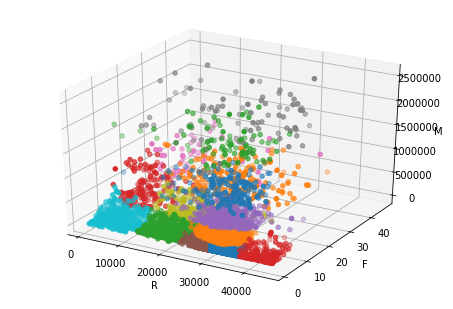

In [22]:
draw_3d_plot(X, (30, -60), rep_kmeans['results'][(14, 17, -3)]['labels'])

In [23]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [ ]:
def clusters2segments(cluster_centers, labels)

In [24]:
cluster_centers, labels = model_kmeans.cluster_centers_, model_kmeans.labels_
n_u_lbs = len(np.unique(labels))
n_u_lbs

12

In [25]:
dtree = DecisionTreeClassifier(max_leaf_nodes=n_u_lbs)
dtree.fit(X_scaled_std, labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=12,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [95]:
dot_data = export_graphviz(dtree, out_file=None, filled=False)
graph = pydotplus.graph_from_dot_data(dot_data)
#graph.write_png('tree.png')
# для этого понадобится библиотека pydot (pip install pydot)
!dot -Tpng 'small_tree.dot' -o 'small_tree.png'

"dot" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


<img src="tree.png.jpg">

In [88]:
import pydotplus
from IPython.display import Image, display

In [ ]:
!conda install graphviz

In [27]:
def get_grid(data, size=50):
    x_min, x_max = data.iloc[:, 0].min() - 1, data.iloc[:, 0].max() + 1
    y_min, y_max = data.iloc[:, 1].min() - 1, data.iloc[:, 1].max() + 1
    z_min, z_max = data.iloc[:, 2].min() - 1, data.iloc[:, 2].max() + 1
    xx, yy, zz = np.meshgrid(np.linspace(x_min, x_max, size), 
                             np.linspace(y_min, y_max, size),
                             np.linspace(y_min, y_max, size))
    data_full = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
    data_full = pd.DataFrame(data=data_full, columns=data.columns)
    return data_full

In [30]:
data_full = get_grid(X_scaled_std, size=40)
predicted = (dtree.predict(data_full))


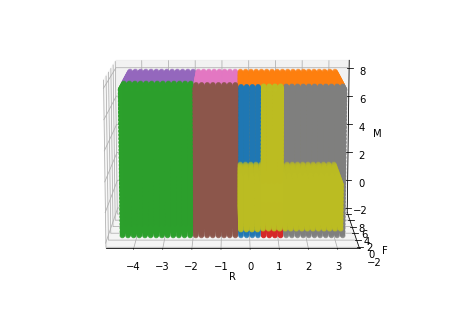

In [34]:
draw_3d_plot(data_full, (10, -90), labels=predicted)

In [25]:
report

{'name': 'AgglomerativeClustering',
 'params': ('n_clusters', 'linkage', 'affinity'),
 'results': OrderedDict([((8, 'average', 'chebyshev'),
               {'labels': array([3, 3, 3, ..., 3, 3, 3], dtype=int64),
                'm1': 0.6275422508387797,
                'm2': 2366.481226636439}),
              ((9, 'average', 'chebyshev'),
               {'labels': array([3, 3, 3, ..., 3, 3, 3], dtype=int64),
                'm1': 0.6251160228175254,
                'm2': 2109.9861318966796}),
              ((10, 'average', 'chebyshev'),
               {'labels': array([1, 1, 1, ..., 1, 1, 1], dtype=int64),
                'm1': 0.6253345711390297,
                'm2': 1901.116171868823}),
              ((11, 'average', 'chebyshev'),
               {'labels': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
                'm1': 0.6213816543095286,
                'm2': 1714.1574693670207}),
              ((12, 'average', 'chebyshev'),
               {'labels': array([8, 8, 8, ..., 8, 8, 8

In [20]:
best = choose_best_result(report['results'])
best

{'m1': {'comb': (8, 'average', 'chebyshev'),
  'labels': array([3, 3, 3, ..., 3, 3, 3], dtype=int64),
  'res': 0.6275422508387797},
 'm2': {'comb': (8, 'average', 'chebyshev'),
  'labels': array([3, 3, 3, ..., 3, 3, 3], dtype=int64),
  'res': 2366.481226636439}}

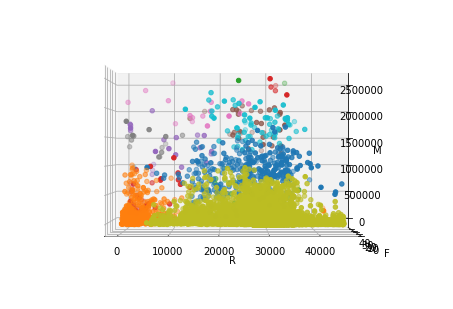

In [32]:
draw_3d_plot(X, (0, -90), report['results'][(14, 'average', 'chebyshev')]['labels'])

In [34]:
params_meanshift = {'cluster_all': [True, False], 
                    'n_jobs': [-3]}
rep_ms = tuning(X_scaled_std, params_meanshift, MeanShift, rs=rs)

In [35]:
rep_ms

{'name': 'MeanShift',
 'params': ('cluster_all', 'n_jobs'),
 'results': OrderedDict([((True, -3),
               {'labels': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
                'm1': 0.5727862395632617,
                'm2': 1199.9634131024836}),
              ((False, -3),
               {'labels': array([ 0,  0, -1, ...,  0,  0,  0]),
                'm1': 0.5118155355189262,
                'm2': 572.2306542418012})])}

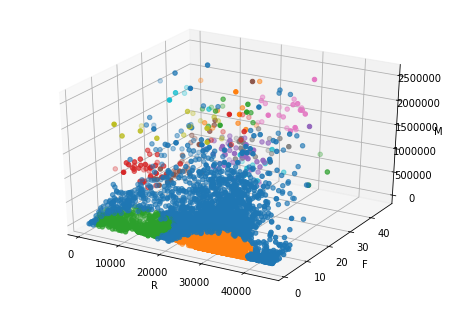

In [38]:
draw_3d_plot(X, (30, -60), rep_ms['results'][(False, -3)]['labels'])

In [52]:
PAIRWISE_KERNEL_FUNCTIONS


{'additive_chi2': <function sklearn.metrics.pairwise.additive_chi2_kernel>,
 'chi2': <function sklearn.metrics.pairwise.chi2_kernel>,
 'cosine': <function sklearn.metrics.pairwise.cosine_similarity>,
 'laplacian': <function sklearn.metrics.pairwise.laplacian_kernel>,
 'linear': <function sklearn.metrics.pairwise.linear_kernel>,
 'poly': <function sklearn.metrics.pairwise.polynomial_kernel>,
 'polynomial': <function sklearn.metrics.pairwise.polynomial_kernel>,
 'rbf': <function sklearn.metrics.pairwise.rbf_kernel>,
 'sigmoid': <function sklearn.metrics.pairwise.sigmoid_kernel>}

In [48]:
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import DistanceMetric

In [49]:
chebyshev_metric = DistanceMetric.get_metric('chebyshev')

In [50]:
params_spectral = {'n_clusters': list(range(n_min, n_max + 1)),
                   'affinity': chebyshev_metric,
                   'n_neighbors': [10, 50, 200],
                   'n_jobs': [-3],
                   'eigen_solver': ['arpack'],
                   'random_state': [rs]}

rep_spectral = tuning(X_scaled_std, params_spectral, SpectralClustering, rs=rs)

TypeError: 'sklearn.neighbors.dist_metrics.ChebyshevDistance' object is not iterable

In [70]:
import plotly.plotly as py
from plotly.graph_objs import Scatter, Data, Surface

In [71]:
def draw_3d_plotly_plot(data, labels=None):
    fig = plt.figure()
    ax = Axes3D(fig)
    
    ax.set_xlabel("R")
    ax.set_ylabel("F")
    ax.set_zlabel("M")
    
    if labels is None:
        x = list(data['rfm_r'])
        y = list(data['rfm_f'])
        z = list(data['rfm_m'])
        
        scatter = Surface(x=x, y=y, z=z)
        plot_data = Data([scatter])
        layout = Layout(
            title='Parametric Plot',
            scene=Scene(
                xaxis=XAxis(
                    gridcolor='rgb(255, 255, 255)',
                    zerolinecolor='rgb(255, 255, 255)',
                    showbackground=True,
                    backgroundcolor='rgb(230, 230,230)'
                ),
                yaxis=YAxis(
                    gridcolor='rgb(255, 255, 255)',
                    zerolinecolor='rgb(255, 255, 255)',
                    showbackground=True,
                    backgroundcolor='rgb(230, 230,230)'
                ),
                zaxis=ZAxis(
                    gridcolor='rgb(255, 255, 255)',
                    zerolinecolor='rgb(255, 255, 255)',
                    showbackground=True,
                    backgroundcolor='rgb(230, 230,230)'
                )
            )
        )
        fig = Figure(data=plot_data, layout=layout)
        py.iplot(fig, filename='jupyter/parametric_plot')
        
    else:
        for n in np.unique(labels):
            indices = labels == n
            x = list(data.loc[indices, 'rfm_r'])
            y = list(data.loc[indices, 'rfm_f'])
            z = list(data.loc[indices, 'rfm_m'])

            c = [[n * 2 % 256, n * 5 % 256, n * 13 % 256]]
            ax.scatter(x, y, z)
    
    return ax

Aw, snap! We don't have an account for ''. Want to try again? You can authenticate with your email address or username. Sign in is not case sensitive.

Don't have an account? plot.ly

Questions? accounts@plot.ly


PlotlyError: Because you didn't supply a 'file_id' in the call, we're assuming you're trying to snag a figure from a url. You supplied the url, '', we expected it to start with 'https://plot.ly'.
Run help on this function for more information.

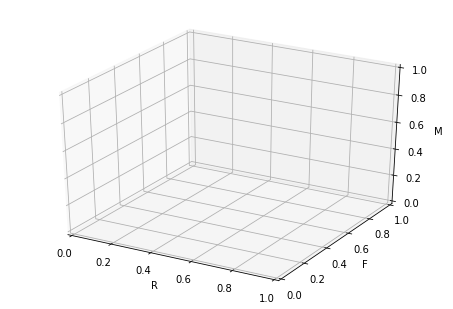

In [72]:
draw_3d_plotly_plot(X)